In [1]:
#| default_exp auto

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

In [3]:
#| export
from os import cpu_count
import torch

from ray import tune
from ray.tune.search.basic_variant import BasicVariantGenerator

from neuralforecast.common._base_auto import BaseAuto

from neuralforecast.models.rnn import RNN
from neuralforecast.models.gru import GRU
from neuralforecast.models.tcn import TCN
from neuralforecast.models.lstm import LSTM
from neuralforecast.models.dilated_rnn import DilatedRNN

from neuralforecast.models.mlp import MLP
from neuralforecast.models.nbeats import NBEATS
from neuralforecast.models.nhits import NHITS

from neuralforecast.models.tft import TFT

from neuralforecast.losses.pytorch import MAE

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#| hide
import matplotlib.pyplot as plt

from fastcore.test import test_eq
from nbdev.showdoc import show_doc

import logging
import warnings

In [5]:
#| hide
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

plt.rcParams["axes.grid"]=True
plt.rcParams['font.family'] = 'serif'
plt.rcParams["figure.figsize"] = (6,4)

# <span style="color:DarkOrange"> Models </span>

> NeuralForecast contains user-friendly implementations of neural forecasting models that allow for easy transition of computing capabilities (GPU/CPU), computation parallelization, and hyperparameter tuning.<br><br> All the NeuralForecast models are "global" because we train them with all the series from the input pd.DataFrame data `Y_df`, yet the optimization objective is, momentarily, "univariate" as it does not consider the interaction between the output predictions across time series. Like the StatsForecast library, `core.NeuralForecast` allows you to explore collections of models efficiently and contains functions for convenient wrangling of input and output pd.DataFrames predictions.

# <span style="color:DarkBlue"> 1. Automatic Forecasting </span>

## <span style="color:DarkBlue"> A. RNN-Based </span>

In [6]:
#| export
class AutoRNN(BaseAuto):
    
    default_config = {
        "input_size_multiplier": [-1, 4, 16, 64],
        "h": None,
        "encoder_hidden_size": tune.choice([50, 100, 200, 300]),
        "encoder_n_layers": tune.randint(1, 4),
        "context_size": tune.choice([5, 10, 50]),
        "decoder_hidden_size": tune.choice([64, 128, 256, 512]),
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "max_steps": tune.choice([500, 1000]),
        "batch_size": tune.choice([16, 32]),
        "loss": None,
        "random_seed": tune.randint(1, 20)
    }

    def __init__(self,
                 h,
                 loss=MAE(),
                 config=None, 
                 search_alg=BasicVariantGenerator(random_state=1),
                 num_samples=10,
                 refit_with_val=False,
                 cpus=cpu_count(),
                 gpus=torch.cuda.device_count(),
                 verbose=False):
        """ Auto RNN
        
        **Parameters:**<br>
        
        """
        # Define search space, input/output sizes
        if config is None:
            config = self.default_config.copy()        
            config['input_size'] = tune.choice([h*x \
                         for x in self.default_config["input_size_multiplier"]])
            del config["input_size_multiplier"]

        super(AutoRNN, self).__init__(
              cls_model=RNN, 
              h=h,
              loss=loss,
              config=config, 
              search_alg=search_alg,
              num_samples=num_samples, 
              refit_with_val=refit_with_val,
              cpus=cpus,
              gpus=gpus,
              verbose=verbose
        )

In [7]:
show_doc(AutoRNN, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/auto.py#L30){target="_blank" style="float:right; font-size:smaller"}

### AutoRNN

>      AutoRNN (h, loss=MAE(), config=None,
>               search_alg=<ray.tune.search.basic_variant.BasicVariantGenerator
>               object at 0x134ada7a0>, num_samples=10, refit_with_val=False,
>               cpus=12, gpus=0, verbose=False)

BaseAuto

Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to
give access to a wide variety of hyperparameter optimization tools ranging
from classic grid search, to Bayesian optimization and HyperBand algorithm.

The validation loss to be optimized is defined by the `config['loss']` dictionary
value, the config also contains the rest of the hyperparameter search space.

It is important to note that the success of this hyperparameter optimization
heavily relies on a strong correlation between the validation and test periods.

**Parameters:**<br>
`cls_model`: PyTorch/PyTorchLightning model, see `neuralforecast.models` [collection here](https://nixtla.github.io/neuralforecast/models.html).<br>
`h`: int, forecast horizon.<br>
`config`: dict, dictionary with ray.tune defined search space.<br>
`search_alg`: ray.tune.search variant, BasicVariantGenerator, HyperOptSearch, DragonflySearch, TuneBOHB for details
    see [tune.search](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#).<br>
`num_samples`: int, number of hyperparameter optimization steps/samples.<br>
`cpus`: int, number of cpus to use during optimization, default all available.<br>
`gpus`: int, number of gpus to use during optimization, default all available.<br>
`refit_wo_val`: bool, number of gpus to use during optimization, default all available.<br>
`verbose`: bool, wether print partial outputs.<br>

In [8]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengersDF as Y_df

# Split train/test and declare time series dataset
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test
dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)

In [9]:
%%capture
# Use your own config or AutoRNN.default_config
config = dict(max_steps=10, val_check_steps=1, input_size=-1, encoder_hidden_size=256)
model = AutoRNN(h=12, config=config, num_samples=1, cpus=1)

model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)

Global seed set to 1


<AxesSubplot:xlabel='ds'>

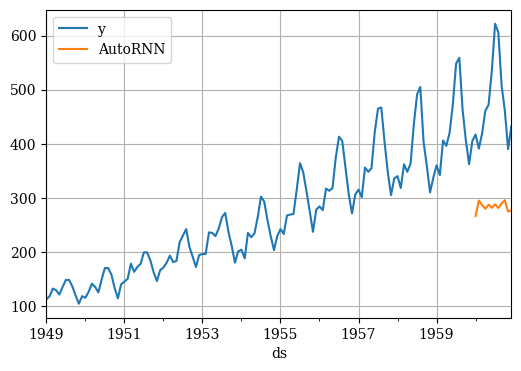

In [10]:
# Plotting predictions
Y_plot_df = Y_test_df[['unique_id', 'ds', 'y']].copy()
Y_plot_df['AutoRNN'] = y_hat

pd.concat([Y_train_df, Y_plot_df]).drop('unique_id', axis=1).set_index('ds').plot()

In [11]:
#| export
class AutoLSTM(BaseAuto):

    default_config = {
        "input_size_multiplier": [-1, 4, 16, 64],
        "h": None,
        "encoder_hidden_size": tune.choice([50, 100, 200, 300]),
        "encoder_n_layers": tune.randint(1, 4),
        "context_size": tune.choice([5, 10, 50]),
        "decoder_hidden_size": tune.choice([64, 128, 256, 512]),
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "max_steps": tune.choice([500, 1000]),
        "batch_size": tune.choice([16, 32]),
        "loss": None,
        "random_seed": tune.randint(1, 20)
    }

    def __init__(self,
                 h,
                 loss=MAE(),
                 config=None,
                 search_alg=BasicVariantGenerator(random_state=1),
                 num_samples=10,
                 refit_with_val=False,
                 cpus=cpu_count(),
                 gpus=torch.cuda.device_count(),
                 verbose=False):

        # Define search space, input/output sizes
        if config is None:
            config = self.default_config.copy()        
            config['input_size'] = tune.choice([h*x \
                         for x in self.default_config["input_size_multiplier"]])
            del config["input_size_multiplier"]

        super(AutoLSTM, self).__init__(
              cls_model=LSTM,
              h=h,
              loss=loss,
              config=config,
              search_alg=search_alg,
              num_samples=num_samples,
              refit_with_val=refit_with_val,
              cpus=cpus,
              gpus=gpus,
              verbose=verbose
        )

In [12]:
show_doc(AutoLSTM, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/auto.py#L85){target="_blank" style="float:right; font-size:smaller"}

### AutoLSTM

>      AutoLSTM (h, loss=MAE(), config=None,
>                search_alg=<ray.tune.search.basic_variant.BasicVariantGenerator
>                object at 0x1f402aa70>, num_samples=10, refit_with_val=False,
>                cpus=12, gpus=0, verbose=False)

BaseAuto

Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to
give access to a wide variety of hyperparameter optimization tools ranging
from classic grid search, to Bayesian optimization and HyperBand algorithm.

The validation loss to be optimized is defined by the `config['loss']` dictionary
value, the config also contains the rest of the hyperparameter search space.

It is important to note that the success of this hyperparameter optimization
heavily relies on a strong correlation between the validation and test periods.

**Parameters:**<br>
`cls_model`: PyTorch/PyTorchLightning model, see `neuralforecast.models` [collection here](https://nixtla.github.io/neuralforecast/models.html).<br>
`h`: int, forecast horizon.<br>
`config`: dict, dictionary with ray.tune defined search space.<br>
`search_alg`: ray.tune.search variant, BasicVariantGenerator, HyperOptSearch, DragonflySearch, TuneBOHB for details
    see [tune.search](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#).<br>
`num_samples`: int, number of hyperparameter optimization steps/samples.<br>
`cpus`: int, number of cpus to use during optimization, default all available.<br>
`gpus`: int, number of gpus to use during optimization, default all available.<br>
`refit_wo_val`: bool, number of gpus to use during optimization, default all available.<br>
`verbose`: bool, wether print partial outputs.<br>

In [13]:
%%capture
# Use your own config or AutoLSTM.default_config
config = dict(max_steps=10, val_check_steps=1, input_size=-1)
model = AutoLSTM(h=12, config=config, num_samples=1, cpus=1)

# Fit and predict
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)

Global seed set to 1


<AxesSubplot:xlabel='ds'>

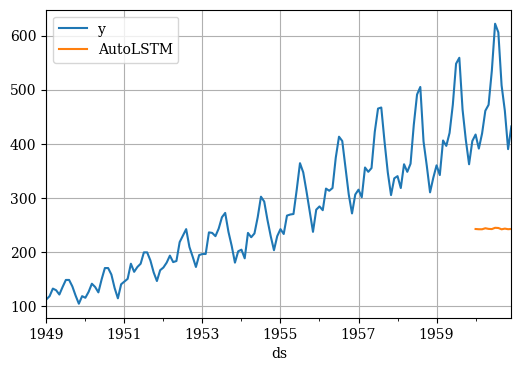

In [14]:
#| hide
Y_plot_df = Y_test_df[['unique_id', 'ds', 'y']].copy()
Y_plot_df['AutoLSTM'] = y_hat

pd.concat([Y_train_df, Y_plot_df]).drop('unique_id', axis=1).set_index('ds').plot()

In [15]:
#| export
class AutoGRU(BaseAuto):

    default_config = {
        "input_size_multiplier": [-1, 4, 16, 64],
        "h": None,
        "encoder_hidden_size": tune.choice([50, 100, 200, 300]),
        "encoder_n_layers": tune.randint(1, 4),
        "context_size": tune.choice([5, 10, 50]),
        "decoder_hidden_size": tune.choice([64, 128, 256, 512]),
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "max_steps": tune.choice([500, 1000]),
        "batch_size": tune.choice([16, 32]),
        "loss": None,
        "random_seed": tune.randint(1, 20)
    }

    def __init__(self,
                 h,
                 loss=MAE(),
                 config=None,
                 search_alg=BasicVariantGenerator(random_state=1),
                 num_samples=10,
                 refit_with_val=False,
                 cpus=cpu_count(),
                 gpus=torch.cuda.device_count(),
                 verbose=False):
        
        # Define search space, input/output sizes
        if config is None:
            config = self.default_config.copy()        
            config['input_size'] = tune.choice([h*x \
                         for x in self.default_config["input_size_multiplier"]])
            del config["input_size_multiplier"]

        super(AutoGRU, self).__init__(
              cls_model=GRU,
              h=h,
              loss=loss,
              config=config, 
              search_alg=search_alg,
              num_samples=num_samples,
              refit_with_val=refit_with_val,
              cpus=cpus,
              gpus=gpus,
              verbose=verbose
        )

In [16]:
show_doc(AutoGRU, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/auto.py#L136){target="_blank" style="float:right; font-size:smaller"}

### AutoGRU

>      AutoGRU (h, loss=MAE(), config=None,
>               search_alg=<ray.tune.search.basic_variant.BasicVariantGenerator
>               object at 0x1f40bc250>, num_samples=10, refit_with_val=False,
>               cpus=12, gpus=0, verbose=False)

BaseAuto

Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to
give access to a wide variety of hyperparameter optimization tools ranging
from classic grid search, to Bayesian optimization and HyperBand algorithm.

The validation loss to be optimized is defined by the `config['loss']` dictionary
value, the config also contains the rest of the hyperparameter search space.

It is important to note that the success of this hyperparameter optimization
heavily relies on a strong correlation between the validation and test periods.

**Parameters:**<br>
`cls_model`: PyTorch/PyTorchLightning model, see `neuralforecast.models` [collection here](https://nixtla.github.io/neuralforecast/models.html).<br>
`h`: int, forecast horizon.<br>
`config`: dict, dictionary with ray.tune defined search space.<br>
`search_alg`: ray.tune.search variant, BasicVariantGenerator, HyperOptSearch, DragonflySearch, TuneBOHB for details
    see [tune.search](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#).<br>
`num_samples`: int, number of hyperparameter optimization steps/samples.<br>
`cpus`: int, number of cpus to use during optimization, default all available.<br>
`gpus`: int, number of gpus to use during optimization, default all available.<br>
`refit_wo_val`: bool, number of gpus to use during optimization, default all available.<br>
`verbose`: bool, wether print partial outputs.<br>

In [17]:
%%capture
# Use your own config or AutoGRU.default_config
config = dict(max_steps=10, val_check_steps=1, input_size=-1)
model = AutoGRU(h=12, config=config, num_samples=1, cpus=1)

# Fit and predict
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)

Global seed set to 1


<AxesSubplot:xlabel='ds'>

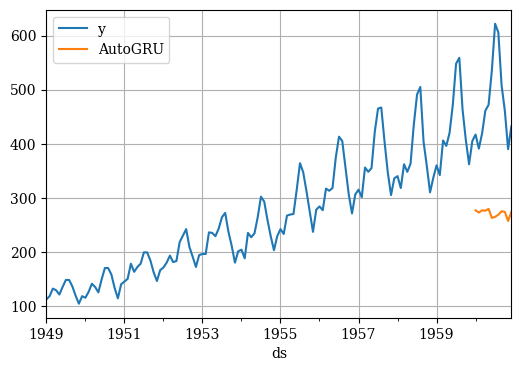

In [18]:
#| hide
Y_plot_df = Y_test_df[['unique_id', 'ds', 'y']].copy()
Y_plot_df['AutoGRU'] = y_hat

pd.concat([Y_train_df, Y_plot_df]).drop('unique_id', axis=1).set_index('ds').plot()

In [19]:
#| export
class AutoTCN(BaseAuto):

    default_config = {
        "input_size_multiplier": [-1, 4, 16, 64],
        "h": None,
        "encoder_hidden_size": tune.choice([50, 100, 200, 300]),
        "context_size": tune.choice([5, 10, 50]),
        "decoder_hidden_size": tune.choice([64, 128]),
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "max_steps": tune.choice([500, 1000]),
        "batch_size": tune.choice([16, 32]),
        "loss": None,
        "random_seed": tune.randint(1, 20)
    }

    def __init__(self,
                 h,
                 loss=MAE(),
                 config=None,
                 search_alg=BasicVariantGenerator(random_state=1),
                 num_samples=10,
                 refit_with_val=False,
                 cpus=cpu_count(),
                 gpus=torch.cuda.device_count(),
                 verbose=False):
        
        # Define search space, input/output sizes
        if config is None:
            config = self.default_config.copy()        
            config['input_size'] = tune.choice([h*x \
                         for x in self.default_config["input_size_multiplier"]])
            del config["input_size_multiplier"]

        super(AutoTCN, self).__init__(
              cls_model=TCN,
              h=h,
              loss=loss,
              config=config, 
              search_alg=search_alg,
              num_samples=num_samples,
              refit_with_val=refit_with_val,
              cpus=cpus,
              gpus=gpus,
              verbose=verbose
        )

In [20]:
show_doc(AutoTCN, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/auto.py#L187){target="_blank" style="float:right; font-size:smaller"}

### AutoTCN

>      AutoTCN (h, loss=MAE(), config=None,
>               search_alg=<ray.tune.search.basic_variant.BasicVariantGenerator
>               object at 0x1f4188250>, num_samples=10, refit_with_val=False,
>               cpus=12, gpus=0, verbose=False)

BaseAuto

Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to
give access to a wide variety of hyperparameter optimization tools ranging
from classic grid search, to Bayesian optimization and HyperBand algorithm.

The validation loss to be optimized is defined by the `config['loss']` dictionary
value, the config also contains the rest of the hyperparameter search space.

It is important to note that the success of this hyperparameter optimization
heavily relies on a strong correlation between the validation and test periods.

**Parameters:**<br>
`cls_model`: PyTorch/PyTorchLightning model, see `neuralforecast.models` [collection here](https://nixtla.github.io/neuralforecast/models.html).<br>
`h`: int, forecast horizon.<br>
`config`: dict, dictionary with ray.tune defined search space.<br>
`search_alg`: ray.tune.search variant, BasicVariantGenerator, HyperOptSearch, DragonflySearch, TuneBOHB for details
    see [tune.search](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#).<br>
`num_samples`: int, number of hyperparameter optimization steps/samples.<br>
`cpus`: int, number of cpus to use during optimization, default all available.<br>
`gpus`: int, number of gpus to use during optimization, default all available.<br>
`refit_wo_val`: bool, number of gpus to use during optimization, default all available.<br>
`verbose`: bool, wether print partial outputs.<br>

In [21]:
%%capture
# Use your own config or AutoTCN.default_config
config = dict(max_steps=10, val_check_steps=1, input_size=-1)
model = AutoTCN(h=12, config=config, num_samples=1, cpus=1)

# Fit and predict
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)

Global seed set to 1


<AxesSubplot:xlabel='ds'>

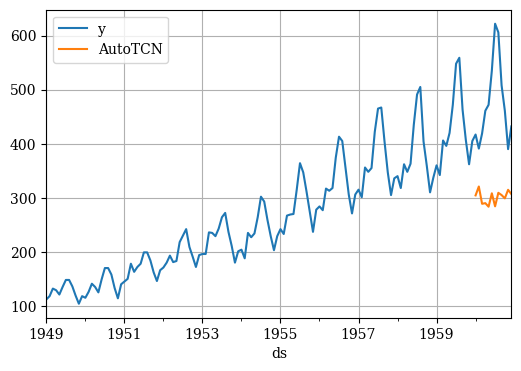

In [22]:
#| hide
Y_plot_df = Y_test_df[['unique_id', 'ds', 'y']].copy()
Y_plot_df['AutoTCN'] = y_hat

pd.concat([Y_train_df, Y_plot_df]).drop('unique_id', axis=1).set_index('ds').plot()

In [23]:
#| export
class AutoDilatedRNN(BaseAuto):

    default_config = {
        "input_size_multiplier": [-1, 4, 16, 64],
        "h": None,
        "cell_type": tune.choice(['LSTM', 'GRU']),
        "encoder_hidden_size": tune.choice([50, 100, 200, 300]),
        "dilations": tune.choice([ [[1, 2], [4, 8]], [[1, 2, 4, 8]] ]),
        "context_size": tune.choice([5, 10, 50]),
        "decoder_hidden_size": tune.choice([64, 128, 256, 512]),
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "max_steps": tune.choice([500, 1000]),
        "batch_size": tune.choice([16, 32]),
        "loss": None,
        "random_seed": tune.randint(1, 20)
    }

    def __init__(self,
                 h,
                 loss=MAE(),
                 config=None,
                 search_alg=BasicVariantGenerator(random_state=1),
                 num_samples=10,
                 refit_with_val=False,
                 cpus=cpu_count(),
                 gpus=torch.cuda.device_count(),
                 verbose=False):
        
        # Define search space, input/output sizes
        if config is None:
            config = self.default_config.copy()        
            config['input_size'] = tune.choice([h*x \
                         for x in self.default_config["input_size_multiplier"]])
            del config["input_size_multiplier"]

        super(AutoDilatedRNN, self).__init__(
              cls_model=DilatedRNN,
              h=h,
              loss=loss,
              config=config,
              search_alg=search_alg,
              num_samples=num_samples, 
              refit_with_val=refit_with_val,
              cpus=cpus,
              gpus=gpus,
              verbose=verbose
         )

In [24]:
show_doc(AutoDilatedRNN, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/auto.py#L237){target="_blank" style="float:right; font-size:smaller"}

### AutoDilatedRNN

>      AutoDilatedRNN (h, loss=MAE(), config=None,
>                      search_alg=<ray.tune.search.basic_variant.BasicVariantGen
>                      erator object at 0x1f42658a0>, num_samples=10,
>                      refit_with_val=False, cpus=12, gpus=0, verbose=False)

BaseAuto

Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to
give access to a wide variety of hyperparameter optimization tools ranging
from classic grid search, to Bayesian optimization and HyperBand algorithm.

The validation loss to be optimized is defined by the `config['loss']` dictionary
value, the config also contains the rest of the hyperparameter search space.

It is important to note that the success of this hyperparameter optimization
heavily relies on a strong correlation between the validation and test periods.

**Parameters:**<br>
`cls_model`: PyTorch/PyTorchLightning model, see `neuralforecast.models` [collection here](https://nixtla.github.io/neuralforecast/models.html).<br>
`h`: int, forecast horizon.<br>
`config`: dict, dictionary with ray.tune defined search space.<br>
`search_alg`: ray.tune.search variant, BasicVariantGenerator, HyperOptSearch, DragonflySearch, TuneBOHB for details
    see [tune.search](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#).<br>
`num_samples`: int, number of hyperparameter optimization steps/samples.<br>
`cpus`: int, number of cpus to use during optimization, default all available.<br>
`gpus`: int, number of gpus to use during optimization, default all available.<br>
`refit_wo_val`: bool, number of gpus to use during optimization, default all available.<br>
`verbose`: bool, wether print partial outputs.<br>

In [25]:
%%capture
# Use your own config or AutoDilatedRNN.default_config
config = dict(max_steps=10, val_check_steps=1, input_size=-1)
model = AutoDilatedRNN(h=12, config=config, num_samples=1, cpus=1)

# Fit and predict
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)

Global seed set to 1


<AxesSubplot:xlabel='ds'>

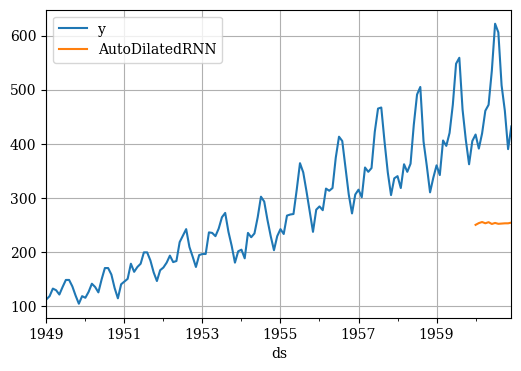

In [26]:
#| hide
Y_plot_df = Y_test_df[['unique_id', 'ds', 'y']].copy()
Y_plot_df['AutoDilatedRNN'] = y_hat

pd.concat([Y_train_df, Y_plot_df]).drop('unique_id', axis=1).set_index('ds').plot()

## <span style="color:DarkBlue"> B. MLP-Based </span>

In [27]:
#| export
class AutoMLP(BaseAuto):

    default_config = {
        "input_size_multiplier": [1, 2, 3, 4, 5],
        "h": None,
        "hidden_size": tune.choice( [256, 512, 1024] ),
        "num_layers": tune.randint(2, 6),
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "scaler_type": tune.choice([None, 'robust', 'standard']),
        "max_steps": tune.choice([500, 1000]),
        "batch_size": tune.choice([32, 64, 128, 256]),
        "windows_batch_size": tune.choice([128, 256, 512, 1024]),
        "loss": None,
        "random_seed": tune.randint(1, 20),
    }

    def __init__(self,
                 h,
                 loss=MAE(),        
                 config=None,
                 search_alg=BasicVariantGenerator(random_state=1),
                 num_samples=10,
                 refit_with_val=False,
                 cpus=cpu_count(),
                 gpus=torch.cuda.device_count(),
                 verbose=False):

        # Define search space, input/output sizes
        if config is None:
            config = self.default_config.copy()        
            config['input_size'] = tune.choice([h*x \
                         for x in self.default_config["input_size_multiplier"]])

            # Rolling windows with step_size=1 or step_size=h
            # See `BaseWindows` and `BaseRNN`'s create_windows
            config['step_size'] = tune.choice([1, h])
            del config["input_size_multiplier"]

        super(AutoMLP, self).__init__(
              cls_model=MLP,
              h=h,
              loss=loss,
              config=config, 
              search_alg=search_alg,
              num_samples=num_samples, 
              refit_with_val=refit_with_val,
              cpus=cpus,
              gpus=gpus,
              verbose=verbose
        )

In [28]:
show_doc(AutoMLP, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/auto.py#L289){target="_blank" style="float:right; font-size:smaller"}

### AutoMLP

>      AutoMLP (h, loss=MAE(), config=None,
>               search_alg=<ray.tune.search.basic_variant.BasicVariantGenerator
>               object at 0x1f5b9e230>, num_samples=10, refit_with_val=False,
>               cpus=12, gpus=0, verbose=False)

BaseAuto

Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to
give access to a wide variety of hyperparameter optimization tools ranging
from classic grid search, to Bayesian optimization and HyperBand algorithm.

The validation loss to be optimized is defined by the `config['loss']` dictionary
value, the config also contains the rest of the hyperparameter search space.

It is important to note that the success of this hyperparameter optimization
heavily relies on a strong correlation between the validation and test periods.

**Parameters:**<br>
`cls_model`: PyTorch/PyTorchLightning model, see `neuralforecast.models` [collection here](https://nixtla.github.io/neuralforecast/models.html).<br>
`h`: int, forecast horizon.<br>
`config`: dict, dictionary with ray.tune defined search space.<br>
`search_alg`: ray.tune.search variant, BasicVariantGenerator, HyperOptSearch, DragonflySearch, TuneBOHB for details
    see [tune.search](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#).<br>
`num_samples`: int, number of hyperparameter optimization steps/samples.<br>
`cpus`: int, number of cpus to use during optimization, default all available.<br>
`gpus`: int, number of gpus to use during optimization, default all available.<br>
`refit_wo_val`: bool, number of gpus to use during optimization, default all available.<br>
`verbose`: bool, wether print partial outputs.<br>

In [29]:
%%capture
# Use your own config or AutoMLP.default_config
config = dict(max_steps=10, val_check_steps=1, input_size=12)
model = AutoMLP(h=12, config=config, num_samples=1, cpus=1)

# Fit and predict
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)

Global seed set to 1


<AxesSubplot:xlabel='ds'>

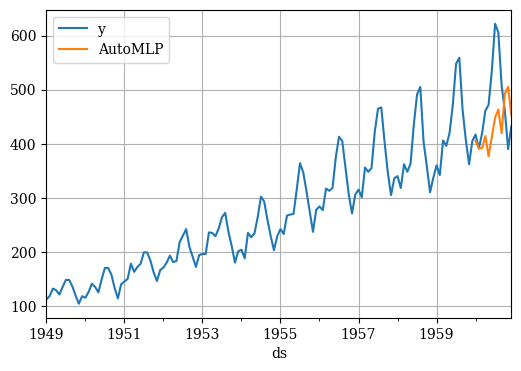

In [30]:
#| hide
Y_plot_df = Y_test_df[['unique_id', 'ds', 'y']].copy()
Y_plot_df['AutoMLP'] = y_hat

pd.concat([Y_train_df, Y_plot_df]).drop('unique_id', axis=1).set_index('ds').plot()

In [31]:
#| export
class AutoNBEATS(BaseAuto):

    default_config = {
        "input_size_multiplier": [1, 2, 3, 4, 5],
        "h": None,
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "scaler_type": tune.choice([None, 'robust', 'standard']),
        "max_steps": tune.choice([500, 1000]),
        "batch_size": tune.choice([32, 64, 128, 256]),
        "windows_batch_size": tune.choice([128, 256, 512, 1024]),
        "loss": None,
        "random_seed": tune.randint(1, 20),
    }

    def __init__(self,
                 h,
                 loss=MAE(),
                 config=None, 
                 search_alg=BasicVariantGenerator(random_state=1),
                 num_samples=10,
                 refit_with_val=False,
                 cpus=cpu_count(),
                 gpus=torch.cuda.device_count(),
                 verbose=False):
        
        # Define search space, input/output sizes
        if config is None:
            config = self.default_config.copy()        
            config['input_size'] = tune.choice([h*x \
                         for x in self.default_config["input_size_multiplier"]])

            # Rolling windows with step_size=1 or step_size=h
            # See `BaseWindows` and `BaseRNN`'s create_windows
            config['step_size'] = tune.choice([1, h])
            del config["input_size_multiplier"]

        super(AutoNBEATS, self).__init__(
              cls_model=NBEATS, 
              h=h,
              loss=loss,
              config=config,
              search_alg=search_alg,
              num_samples=num_samples, 
              refit_with_val=refit_with_val,
              cpus=cpus,
              gpus=gpus,
              verbose=verbose
        )

In [32]:
show_doc(AutoNBEATS, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/auto.py#L344){target="_blank" style="float:right; font-size:smaller"}

### AutoNBEATS

>      AutoNBEATS (h, loss=MAE(), config=None,
>                  search_alg=<ray.tune.search.basic_variant.BasicVariantGenerat
>                  or object at 0x1f5c719f0>, num_samples=10,
>                  refit_with_val=False, cpus=12, gpus=0, verbose=False)

BaseAuto

Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to
give access to a wide variety of hyperparameter optimization tools ranging
from classic grid search, to Bayesian optimization and HyperBand algorithm.

The validation loss to be optimized is defined by the `config['loss']` dictionary
value, the config also contains the rest of the hyperparameter search space.

It is important to note that the success of this hyperparameter optimization
heavily relies on a strong correlation between the validation and test periods.

**Parameters:**<br>
`cls_model`: PyTorch/PyTorchLightning model, see `neuralforecast.models` [collection here](https://nixtla.github.io/neuralforecast/models.html).<br>
`h`: int, forecast horizon.<br>
`config`: dict, dictionary with ray.tune defined search space.<br>
`search_alg`: ray.tune.search variant, BasicVariantGenerator, HyperOptSearch, DragonflySearch, TuneBOHB for details
    see [tune.search](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#).<br>
`num_samples`: int, number of hyperparameter optimization steps/samples.<br>
`cpus`: int, number of cpus to use during optimization, default all available.<br>
`gpus`: int, number of gpus to use during optimization, default all available.<br>
`refit_wo_val`: bool, number of gpus to use during optimization, default all available.<br>
`verbose`: bool, wether print partial outputs.<br>

In [33]:
%%capture
# Use your own config or AutoNBEATS.default_config
config = dict(max_steps=10, val_check_steps=1, input_size=12)
model = AutoNBEATS(h=12, config=config, num_samples=1, cpus=1)

# Fit and predict
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)

Global seed set to 1


<AxesSubplot:xlabel='ds'>

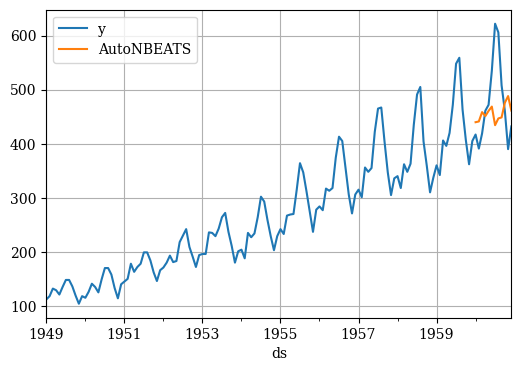

In [34]:
#| hide
Y_plot_df = Y_test_df[['unique_id', 'ds', 'y']].copy()
Y_plot_df['AutoNBEATS'] = y_hat

pd.concat([Y_train_df, Y_plot_df]).drop('unique_id', axis=1).set_index('ds').plot()

In [35]:
#| export
class AutoNHITS(BaseAuto):

    default_config = {
       "input_size_multiplier": [1, 2, 3, 4, 5],
       "h": None,
       "n_pool_kernel_size": tune.choice([3*[1], 3*[2], 3*[4], 
                                          [8, 4, 1], [16, 8, 1]]),
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], 
                                         [180, 60, 1], [60, 8, 1], 
                                         [40, 20, 1], [1, 1, 1]]),
       "learning_rate": tune.loguniform(1e-4, 1e-1),
       "scaler_type": tune.choice([None, 'robust', 'standard']),
       "max_steps": tune.choice([500, 1000]),
       "batch_size": tune.choice([32, 64, 128, 256]),
       "windows_batch_size": tune.choice([128, 256, 512, 1024]),
       "loss": None,
       "random_seed": tune.randint(1, 20),
    }

    def __init__(self,
                 h,
                 loss=MAE(),
                 config=None, 
                 search_alg=BasicVariantGenerator(random_state=1),
                 num_samples=10,
                 refit_with_val=False,
                 cpus=cpu_count(),
                 gpus=torch.cuda.device_count(),
                 verbose=False):

        # Define search space, input/output sizes
        if config is None:
            config = self.default_config.copy()        
            config['input_size'] = tune.choice([h*x \
                         for x in self.default_config["input_size_multiplier"]])
            
            # Rolling windows with step_size=1 or step_size=h
            # See `BaseWindows` and `BaseRNN`'s create_windows
            config['step_size'] = tune.choice([1, h])
            del config["input_size_multiplier"]

        super(AutoNHITS, self).__init__(
              cls_model=NHITS, 
              h=h,
              loss=loss,
              config=config,
              search_alg=search_alg,
              num_samples=num_samples,
              refit_with_val=refit_with_val,
              cpus=cpus,
              gpus=gpus,
              verbose=verbose
        )

In [36]:
show_doc(AutoNHITS, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/auto.py#L397){target="_blank" style="float:right; font-size:smaller"}

### AutoNHITS

>      AutoNHITS (h, loss=MAE(), config=None,
>                 search_alg=<ray.tune.search.basic_variant.BasicVariantGenerato
>                 r object at 0x1f5d45810>, num_samples=10,
>                 refit_with_val=False, cpus=12, gpus=0, verbose=False)

BaseAuto

Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to
give access to a wide variety of hyperparameter optimization tools ranging
from classic grid search, to Bayesian optimization and HyperBand algorithm.

The validation loss to be optimized is defined by the `config['loss']` dictionary
value, the config also contains the rest of the hyperparameter search space.

It is important to note that the success of this hyperparameter optimization
heavily relies on a strong correlation between the validation and test periods.

**Parameters:**<br>
`cls_model`: PyTorch/PyTorchLightning model, see `neuralforecast.models` [collection here](https://nixtla.github.io/neuralforecast/models.html).<br>
`h`: int, forecast horizon.<br>
`config`: dict, dictionary with ray.tune defined search space.<br>
`search_alg`: ray.tune.search variant, BasicVariantGenerator, HyperOptSearch, DragonflySearch, TuneBOHB for details
    see [tune.search](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#).<br>
`num_samples`: int, number of hyperparameter optimization steps/samples.<br>
`cpus`: int, number of cpus to use during optimization, default all available.<br>
`gpus`: int, number of gpus to use during optimization, default all available.<br>
`refit_wo_val`: bool, number of gpus to use during optimization, default all available.<br>
`verbose`: bool, wether print partial outputs.<br>

In [37]:
%%capture
# Use your own config or AutoNHITS.default_config
config = dict(max_steps=1, val_check_steps=1, input_size=12)
model = AutoNHITS(h=12, config=config, num_samples=1, cpus=1)

# Fit and predict
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)

Global seed set to 1


<AxesSubplot:xlabel='ds'>

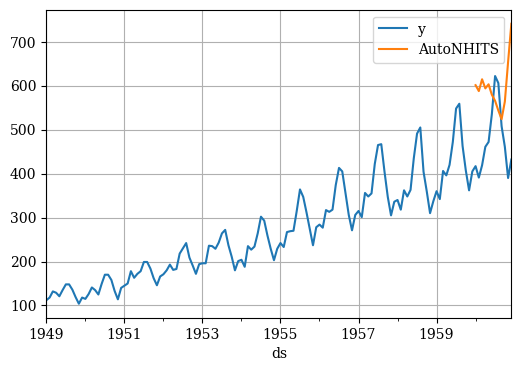

In [38]:
#| hide
Y_plot_df = Y_test_df[['unique_id', 'ds', 'y']].copy()
Y_plot_df['AutoNHITS'] = y_hat

pd.concat([Y_train_df, Y_plot_df]).drop('unique_id', axis=1).set_index('ds').plot()

## <span style="color:DarkBlue"> C. Transformer-Based </span>

In [39]:
#| export
class AutoTFT(BaseAuto):

    default_config = {
        "input_size_multiplier": [1, 2, 3, 4, 5],
        "h": None,
        "hidden_size": tune.choice([64, 128, 256]),
        "n_head": tune.choice([4, 8]),
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "scaler_type": tune.choice([None, 'robust', 'standard']),
        "max_steps": tune.choice([500, 1000, 2000]),
        "batch_size": tune.choice([32, 64, 128, 256]),
        "windows_batch_size": tune.choice([128, 256, 512, 1024]),
        "loss": None,
        "random_seed": tune.randint(1, 20),
    }

    def __init__(self,
                 h,
                 loss=MAE(),
                 config=None, 
                 search_alg=BasicVariantGenerator(random_state=1),
                 num_samples=10,
                 refit_with_val=False,
                 cpus=cpu_count(),
                 gpus=torch.cuda.device_count(),
                 verbose=False):
        
        # Define search space, input/output sizes
        if config is None:
            config = self.default_config.copy()        
            config['input_size'] = tune.choice([h*x \
                         for x in self.default_config["input_size_multiplier"]])

            # Rolling windows with step_size=1 or step_size=h
            # See `BaseWindows` and `BaseRNN`'s create_windows
            config['step_size'] = tune.choice([1, h])
            del config["input_size_multiplier"]

        super(AutoTFT, self).__init__(
              cls_model=TFT, 
              h=h,
              loss=loss,
              config=config,
              search_alg=search_alg,
              num_samples=num_samples, 
              refit_with_val=refit_with_val,
              cpus=cpus,
              gpus=gpus,
              verbose=verbose
        )

In [40]:
show_doc(AutoTFT, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/auto.py#L463){target="_blank" style="float:right; font-size:smaller"}

### AutoTFT

>      AutoTFT (h, loss=MAE(), config=None,
>               search_alg=<ray.tune.search.basic_variant.BasicVariantGenerator
>               object at 0x1f5e3ff40>, num_samples=10, refit_with_val=False,
>               cpus=12, gpus=0, verbose=False)

BaseAuto

Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to
give access to a wide variety of hyperparameter optimization tools ranging
from classic grid search, to Bayesian optimization and HyperBand algorithm.

The validation loss to be optimized is defined by the `config['loss']` dictionary
value, the config also contains the rest of the hyperparameter search space.

It is important to note that the success of this hyperparameter optimization
heavily relies on a strong correlation between the validation and test periods.

**Parameters:**<br>
`cls_model`: PyTorch/PyTorchLightning model, see `neuralforecast.models` [collection here](https://nixtla.github.io/neuralforecast/models.html).<br>
`h`: int, forecast horizon.<br>
`config`: dict, dictionary with ray.tune defined search space.<br>
`search_alg`: ray.tune.search variant, BasicVariantGenerator, HyperOptSearch, DragonflySearch, TuneBOHB for details
    see [tune.search](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#).<br>
`num_samples`: int, number of hyperparameter optimization steps/samples.<br>
`cpus`: int, number of cpus to use during optimization, default all available.<br>
`gpus`: int, number of gpus to use during optimization, default all available.<br>
`refit_wo_val`: bool, number of gpus to use during optimization, default all available.<br>
`verbose`: bool, wether print partial outputs.<br>

In [41]:
%%capture
# Use your own config or AutoNHITS.default_config
config = dict(max_steps=1, val_check_steps=1, input_size=12)
model = AutoTFT(h=12, config=config, num_samples=1, cpus=1)

# Fit and predict
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)

Global seed set to 1


<AxesSubplot:xlabel='ds'>

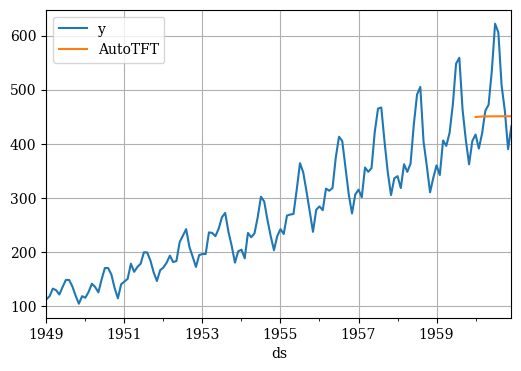

In [42]:
#| hide
Y_plot_df = Y_test_df[['unique_id', 'ds', 'y']].copy()
Y_plot_df['AutoTFT'] = y_hat

pd.concat([Y_train_df, Y_plot_df]).drop('unique_id', axis=1).set_index('ds').plot()

In [43]:
#| hide
## TESTS
config = dict(max_steps=1, val_check_steps=1, input_size=12)
model = AutoNHITS(h=12, config=config, num_samples=1, cpus=1)

# Fit and predict
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)

(train_tune pid=21038) Global seed set to 1


Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             


Global seed set to 1


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=39.5, v_num=0, train_loss_step=39.50]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  6.54it/s, loss=39.5, v_num=0, train_loss_step=39.50, val_loss=112.0, train_loss_epoch=39.50]


(train_tune pid=21038) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=21038)   warnings.warn('resource_tracker: There appear to be %d '


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.46it/s]


In [44]:
#| hide
## TESTS
nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([1]),                                            # Number of SGD steps
       "val_check_steps": tune.choice([1]),                                      # Number of steps between validation
       "input_size": tune.choice([5 * 12]),                                      # input_size = multiplier * horizon
       "batch_size": tune.choice([7]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "random_seed": tune.randint(1, 10),
    }

model = AutoNHITS(h=12, loss=MAE(), config=nhits_config, num_samples=1, cpus=1)

# Fit and predict
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)

(train_tune pid=21062) Global seed set to 2


Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             


(train_tune pid=21062) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=21062)   warnings.warn('resource_tracker: There appear to be %d '
Global seed set to 2


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  2.57it/s, loss=52.6, v_num=0, train_loss_step=52.60]
Validation: 0it [00:00, ?it/s]0m 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.02it/s]
